In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#Disclaimer: I don't know what i m doing :P
#Just trying to learn how a UNET works

In [2]:
#Functions for loading the dataset
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os

decoder = {
    "png":tf.image.decode_png,
    "jpeg":tf.image.decode_jpeg,
    "image":tf.image.decode_image,
    "bpm":tf.image.decode_bmp,
    "gif":tf.image.decode_gif
}

def load_and_preprocess_image(input_path, output_path, target_size=(256, 256),img_format="png",grayscale=False):

    input_image = tf.io.read_file(input_path)
    output_image = tf.io.read_file(output_path)

    input_image = decoder.get(img_format,"png")(input_image, channels=3)
    output_image = decoder.get(img_format,"png")(output_image, channels=3)

    input_image = tf.image.resize(input_image, target_size)
    output_image = tf.image.resize(output_image, target_size)

    if grayscale:
        input_image = tf.image.rgb_to_grayscale(input_image)
        output_image = tf.image.rgb_to_grayscale(output_image)

    input_image = tf.cast(input_image, tf.float32) / 255.0
    output_image = tf.cast(output_image, tf.float32) / 255.0

    return input_image, output_image

def create_dataset(input_folder, output_folder,img_format="png", target_size=(256, 256), batch_size=16, test_size=0.2, shuffle=True,grayscale=False):

    input_files = sorted(os.listdir(input_folder))
    output_files = sorted(os.listdir(output_folder))

    assert len(input_files) == len(output_files), "Input and Output folders must have the same number of files."

    input_paths = [os.path.join(input_folder, fname) for fname in input_files]
    output_paths = [os.path.join(output_folder, fname) for fname in output_files]

    train_input_paths, val_input_paths, train_output_paths, val_output_paths = train_test_split(
        input_paths, output_paths, test_size=test_size, random_state=42
    )

    train_dataset = tf.data.Dataset.from_tensor_slices((train_input_paths, train_output_paths))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_input_paths, val_output_paths))

    train_dataset = train_dataset.map(
        lambda input_path, output_path: load_and_preprocess_image(input_path, output_path,target_size,img_format=img_format,grayscale=grayscale),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_dataset = val_dataset.map(
        lambda input_path, output_path: load_and_preprocess_image(input_path, output_path, target_size,img_format=img_format,grayscale=grayscale),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if shuffle:
        train_dataset = train_dataset.shuffle(buffer_size=len(train_input_paths))
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset

In [3]:
#UNET Functions
import keras
from keras.src.layers import Dropout, BatchNormalization, LeakyReLU, ReLU, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from keras.src.models import Model

activations = {
    'relu': ReLU,
    'leaky_relu': LeakyReLU
}

def IdentityBlock(x):

    return x

def Normalize(x, normalize):

    return BatchNormalization()(x) if normalize else x

def DropOut(x, drop_out):

    return Dropout(drop_out)(x) if 0.0 < drop_out < 1.0 else x

def EncoderBlock(input_block, filter_size, kernel_size=3, padding="same",
                 activation="relu", slope=0.0, pool_size=(2,2),
                 batch_normalization=False, drop_out=0.0):

    conv = Conv2D(filters=filter_size, kernel_size=kernel_size, padding=padding)(input_block)
    conv = Normalize(conv, batch_normalization)
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)

    conv = Conv2D(filters=filter_size, kernel_size=kernel_size, padding=padding)(conv)
    conv = Normalize(conv, batch_normalization)
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)

    pool = MaxPooling2D(pool_size=pool_size)(conv)
    pool = DropOut(pool, drop_out)

    return conv, pool

def BottleneckBlock(input_block, filter_size, kernel_size=3, padding="same",
                    activation="relu", slope=0.0, batch_normalization=False):

    conv = Conv2D(filters=filter_size, kernel_size=kernel_size, padding=padding)(input_block)
    conv = Normalize(conv, batch_normalization)
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)

    conv = Conv2D(filters=filter_size, kernel_size=kernel_size, padding=padding)(conv)
    conv = Normalize(conv, batch_normalization)
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)

    return conv

def DecoderBlock(input_block, original_block, filter_size, kernel_size=3, padding="same",
                 activation="relu", slope=0.0, batch_normalization=False, drop_out=0.0):

    up = UpSampling2D(size=(2,2))(input_block)
    up = Conv2D(filters=filter_size, kernel_size=kernel_size-1, padding=padding)(up)
    up = Normalize(up, batch_normalization)
    up = activations.get(activation, ReLU)(negative_slope=slope)(up)

    merge = concatenate([original_block, up], axis=3)

    conv = Conv2D(filters=filter_size, kernel_size=kernel_size, padding=padding)(merge)
    conv = Normalize(conv, batch_normalization)
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)

    conv = Conv2D(filters=filter_size, kernel_size=kernel_size, padding=padding)(conv)
    conv = Normalize(conv, batch_normalization)
    conv = activations.get(activation, ReLU)(negative_slope=slope)(conv)

    return conv

#I know , kinda unecessary, but why not ?
def OutputBlock(input_block,num_of_classes = 1,kernel_size=1,activation = "sigmoid",padding="same"):
    return Conv2D(filters=num_of_classes,kernel_size=kernel_size,activation=activation,padding=padding)(input_block)


def U_NET(inputs,outputs):
    return Model(inputs,outputs)

In [4]:
input_dir = '/kaggle/input/leukemia-segmentation-dataset/Input'
output_dir = '/kaggle/input/leukemia-segmentation-dataset/Output'

train_dataset,test_dataset = create_dataset(
    input_dir,
    output_dir,                              
    target_size=(224,224),
    batch_size=16,
    img_format='jpeg',
    grayscale=True)

In [5]:
#Building the model
inputs = Input(shape=(224,224,1))

conv1,pool1 = EncoderBlock(inputs,filter_size=64,batch_normalization=True)
conv2,pool2 = EncoderBlock(pool1,filter_size=128,batch_normalization=True)
conv3,pool3 = EncoderBlock(pool2,filter_size=256,batch_normalization=True)

neck = BottleneckBlock(pool3,filter_size=512,batch_normalization=True)

up1 =  DecoderBlock(neck,conv3,filter_size=256,batch_normalization=True)
up2 =  DecoderBlock(up1,conv2,filter_size=128,batch_normalization=True)
up3 =  DecoderBlock(up2,conv1,filter_size=64,batch_normalization=True)

outputs = OutputBlock(up3)

model = U_NET(inputs=inputs,outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 224, 224, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 224, 224, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 112, 112, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 112, 112, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 7,709,249 (29.41 MB)

 Trainable params: 7,702,721 (29.38 MB)

 Non-trainable params: 6,528 (25.50 KB)

In [6]:
#Training
from keras.src.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

model.compile(
    optimizer='adam',
    loss="binary_crossentropy"
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/leucemie_seg.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - loss: 0.1981 - val_loss: 0.2018 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 767ms/step - loss: 0.1045 - val_loss: 0.3461 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 769ms/step - loss: 0.0990 - val_loss: 0.1311 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 770ms/step - loss: 0.0961 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 769ms/step - loss: 0.0940 - val_loss: 0.0949 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 766ms/step - loss: 0.0922 - val_loss: 0.0958 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 765ms/step - loss: 0.0905 - val_loss: 0.1069 - learning_rate: 0.0010
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 766ms/step - loss: 0.0894 - val_loss: 0.0985 - learning_rate: 0.0010
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 770ms/step - loss: 0.0921 - val_loss: 0.0864 -

In [12]:
#Gradient mask function

def apply_gradient(mask,colors):
    height, width = mask.shape
    gradient_image = np.zeros((height, width, 3))  # Create an empty RGB image
    growth = 1/(len(colors)-1)
    for y in range(height):
        for x in range(width):
            value = mask[y, x]
            interval = (int)(value / growth) if value<1 else len(colors)-2

            t = (value - growth * interval) * 2
            gradient_image[y, x] = (1 - t) * colors[interval] + t * colors[interval+1]

    return gradient_image


In [24]:
test_input = None
test_output = None

for image, label in test_dataset.take(1):
    test_input = (image.numpy())
    test_output = (label.numpy())

16

In [27]:
predictions = model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


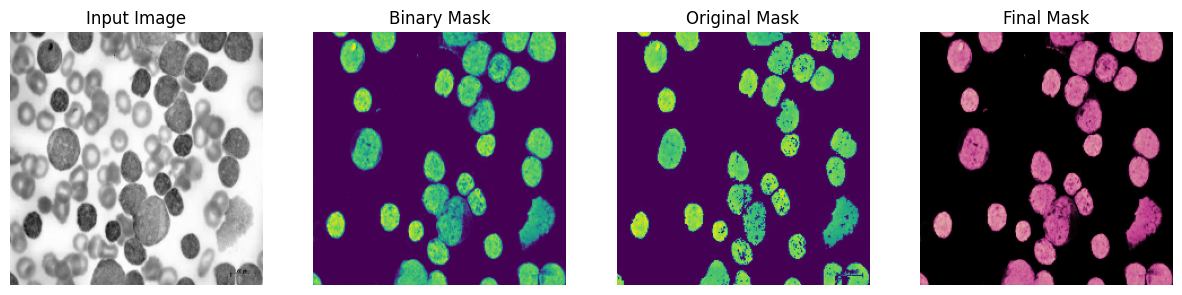

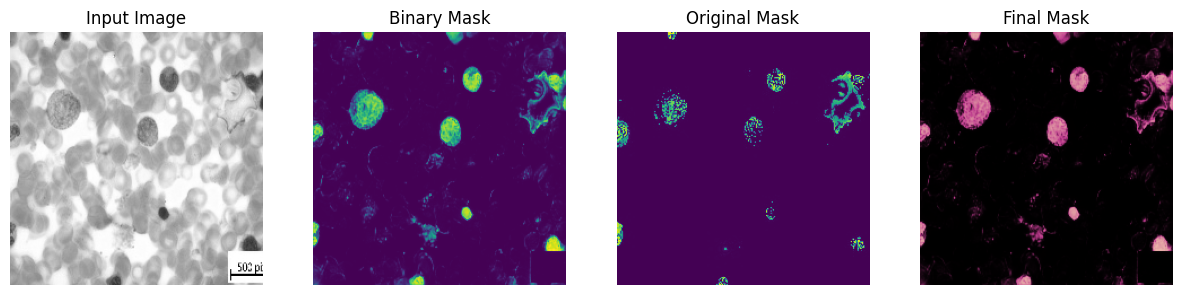

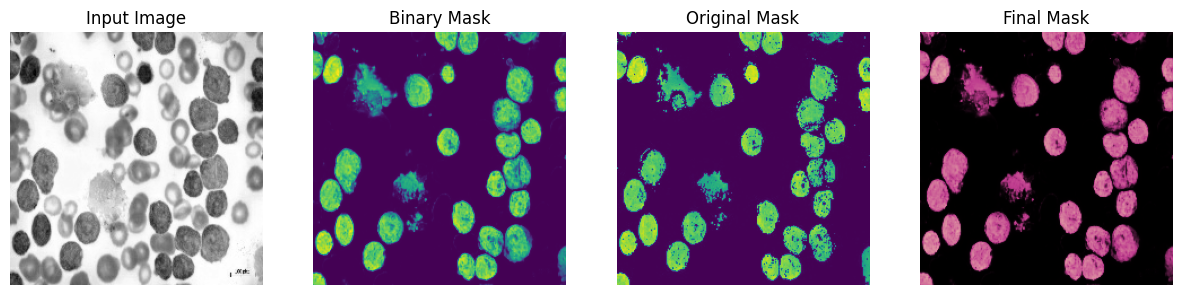

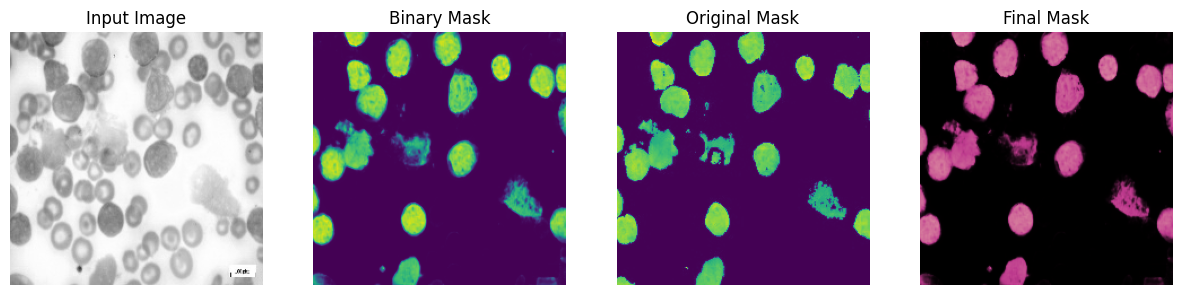

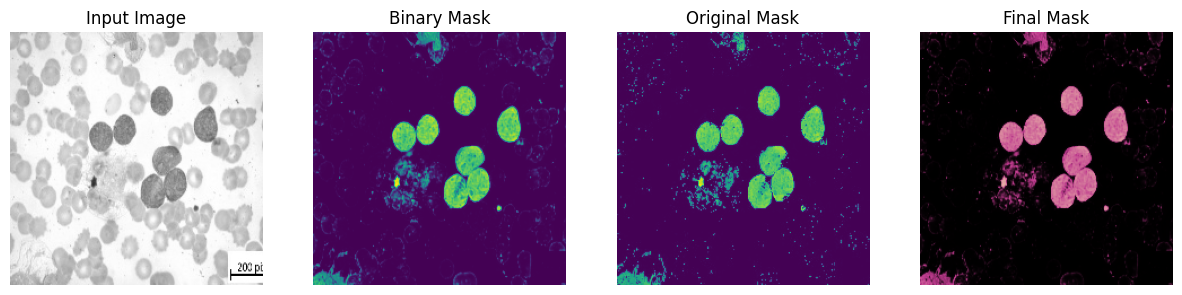

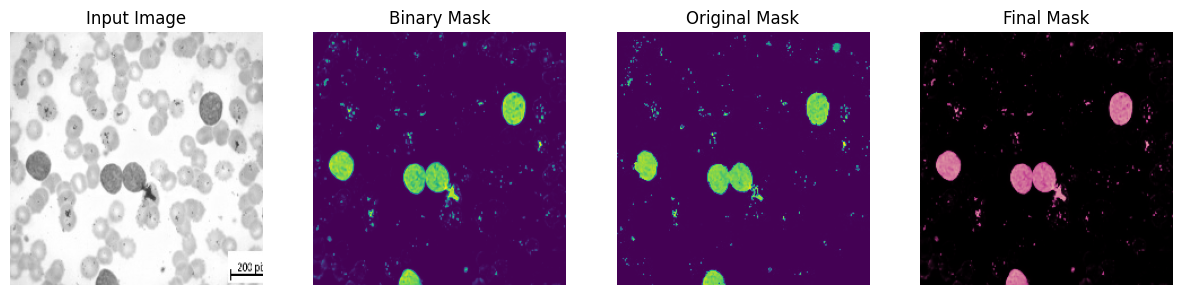

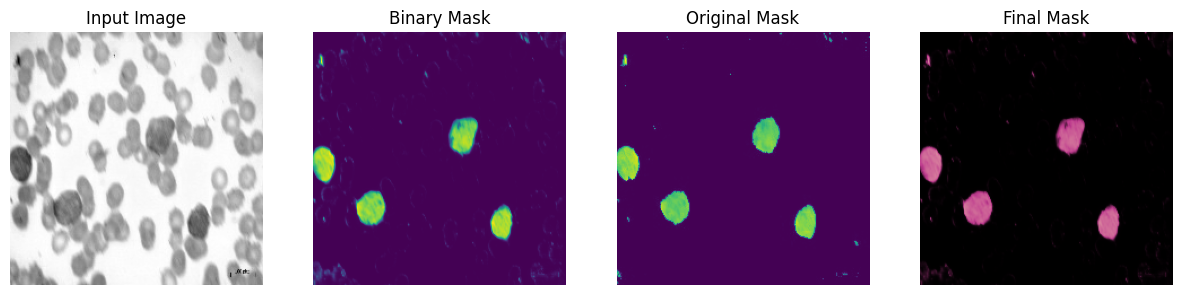

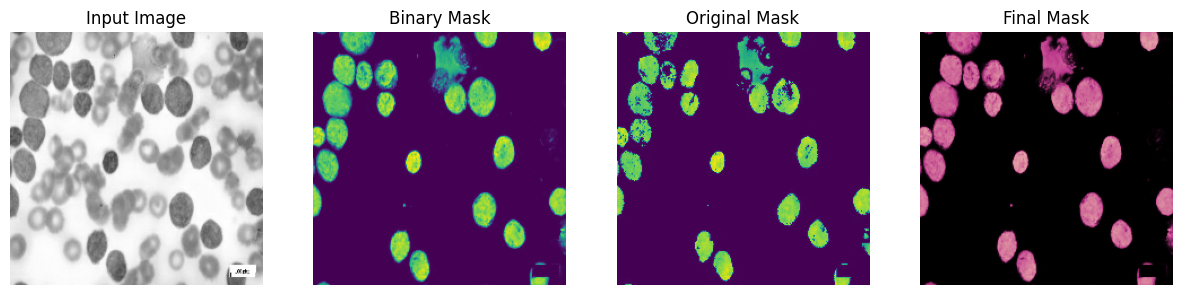

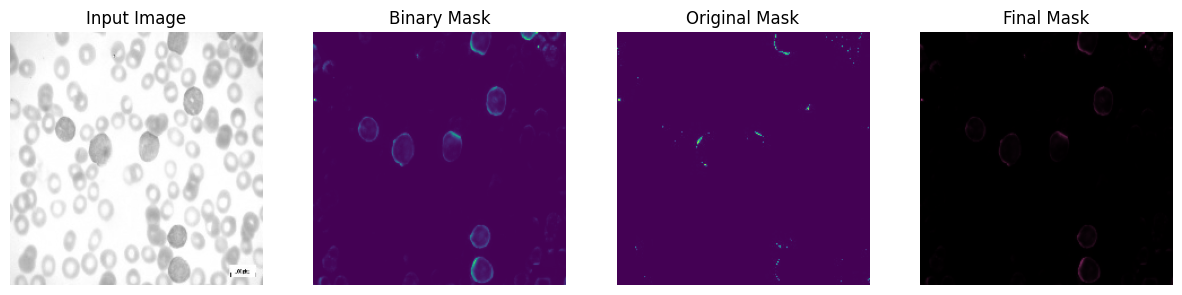

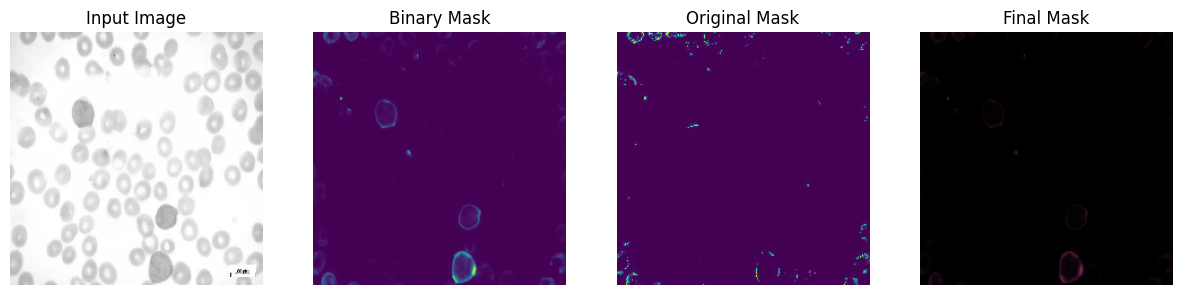

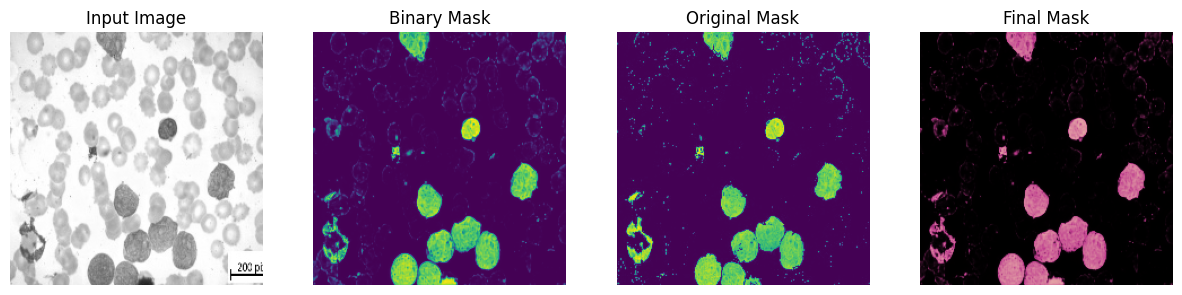

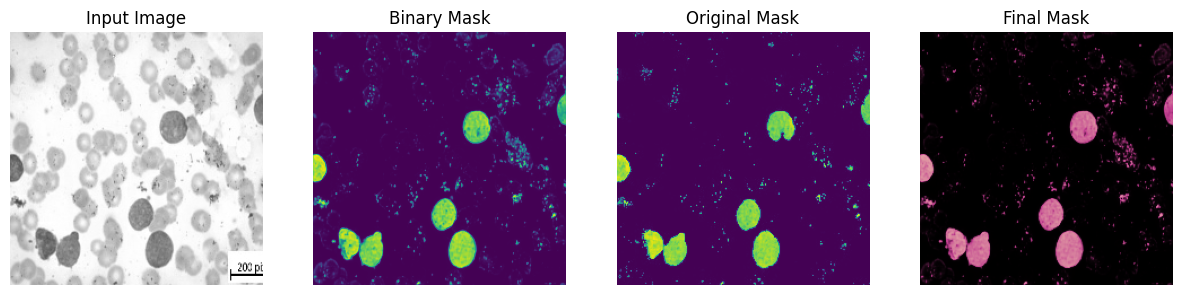

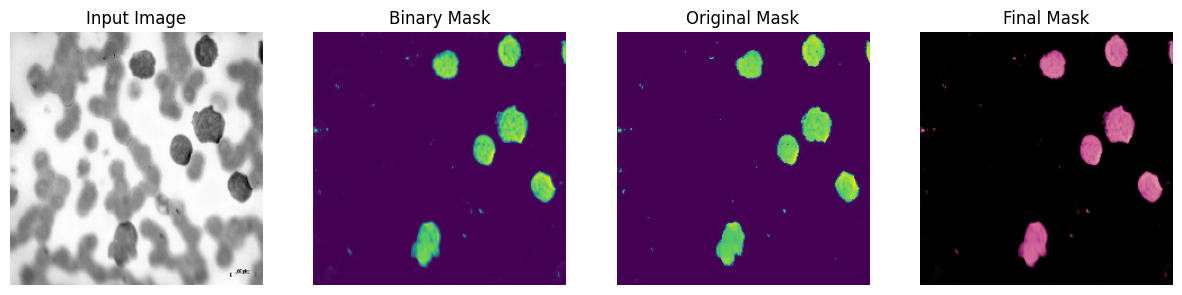

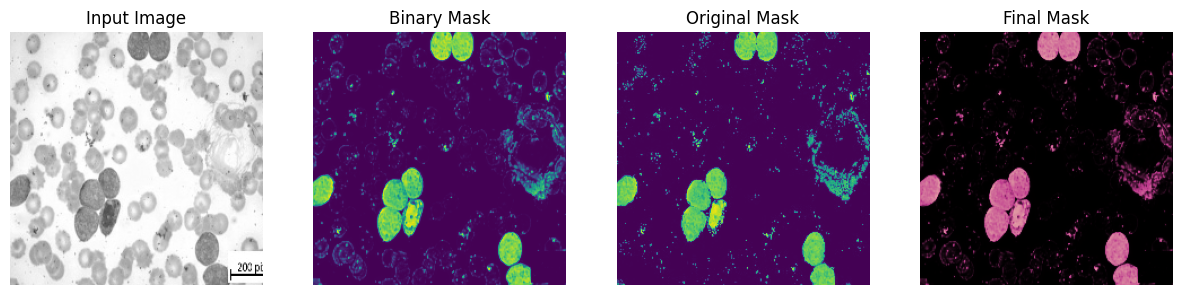

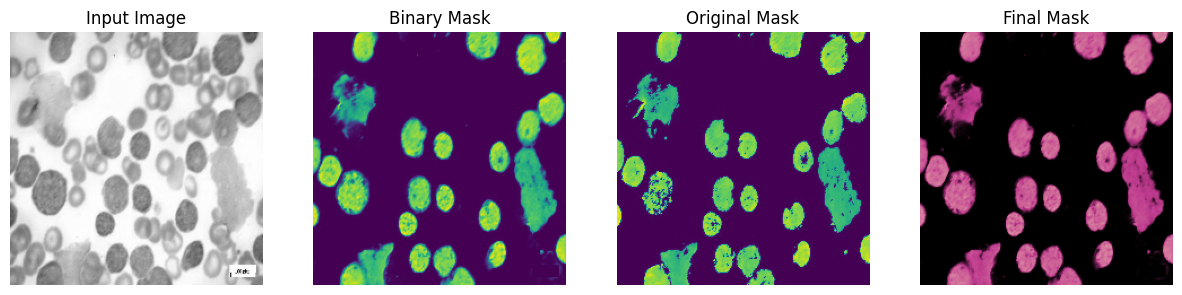

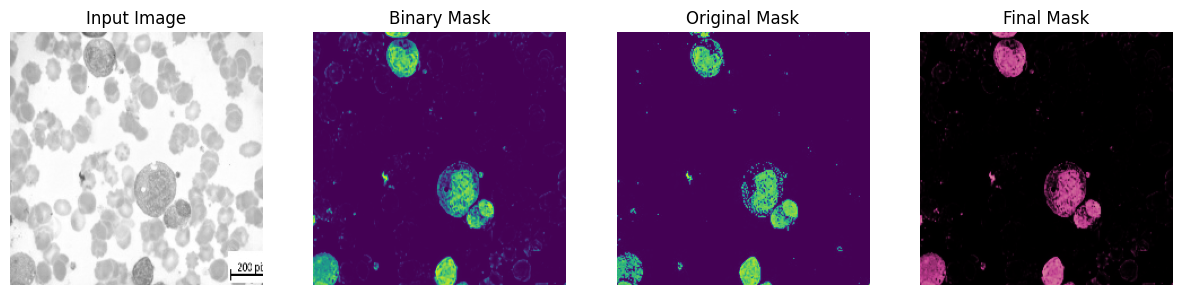

In [46]:
#Output visualization
import matplotlib.pyplot as plt

colors = [
    np.array([0, 0, 0]),         
    np.array([190,58,142])/255,  
    np.array([249,220,178])/255 
]

for input_image,output_image,prediction in zip(test_input,test_output,predictions):
    binary_mask = prediction[:, :, 0] 
    gradient_mask = apply_gradient(binary_mask,colors)


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.title("Input Image")
    plt.imshow(input_image,cmap='gray')
    plt.axis('off')


    plt.subplot(1, 4, 2)
    plt.title("Binary Mask")
    plt.imshow(binary_mask) 
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Original Mask")
    plt.imshow(output_image)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Final Mask")
    plt.imshow(gradient_mask)
    plt.axis('off')



    plt.show()